In [96]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

In [97]:
suspicious_peaks = np.load(r"C:\Users\victo\VSCode Folder\mass_spec_project\data\suspicious_peaks\suspicious_peaks.npz", allow_pickle=True)
grids = suspicious_peaks["grids"]
mz_axes = suspicious_peaks["mz_axes"]
rt_axes = suspicious_peaks["rt_axes"]

MIN_INTENSITY = 3e4
MAX_COMPONENTS = 2
results = []

In [98]:
def delta_bic_to_confidence_score(delta_bic, saturation=20):
    return min(1.0, delta_bic / saturation) * 100

In [99]:
def plot_horizontal_gmm(grid, mz_axis, rt_axis, gmm, scaler, region_idx, mz_boost):
    from matplotlib.patches import Ellipse

    grid = np.array(grid, dtype=float)
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    
    plt.imshow(grid, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Region {region_idx} – GMM Overlay ({gmm.n_components} component(s))")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Intensity')

    for mean, cov in zip(gmm.means_, gmm.covariances_):
        mean_orig = scaler.inverse_transform(mean.reshape(1, -1))[0]
        mean_orig[0] /= mz_boost  # ← UNDO dynamic anisotropy

        # Ellipse parameters from cov
        v, w = np.linalg.eigh(cov)
        v = 2.0 * np.sqrt(v)  # stddev scaling
        angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))

        # Undo anisotropy scaling
        v[0] /= mz_boost  # ← UNDO here too

        # Convert to ellipse width/height in original units
        width = v[1] * scaler.scale_[1]  # RT
        height = v[0] * scaler.scale_[0]  # m/z

        ell = Ellipse(
            xy=(mean_orig[1], mean_orig[0]),  # (RT, m/z)
            width=width,
            height=height,
            angle=angle,
            edgecolor='red',
            fc='None',
            lw=2
        )
        plt.gca().add_patch(ell)

    plt.tight_layout()
    plt.show()


Region 0: Best model has 2 peak(s). ΔBIC = 30.11 → Confidence ≈ 100.0%


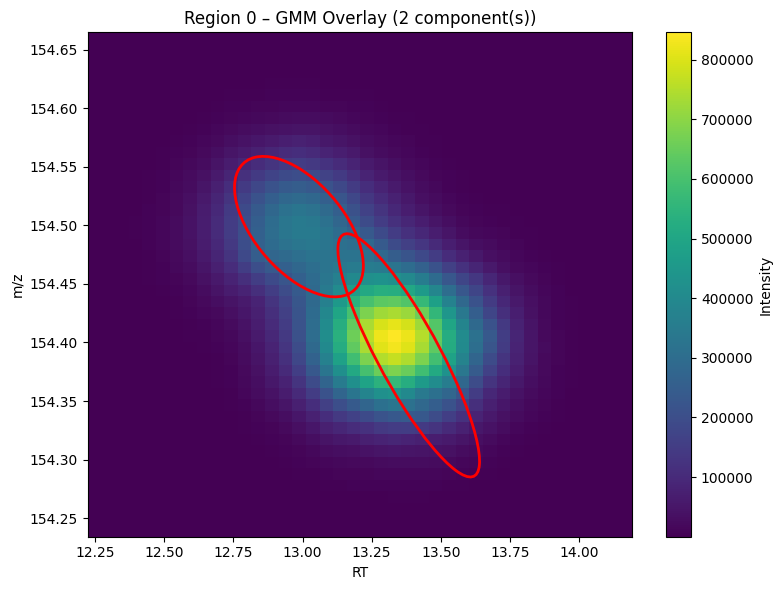

In [100]:
for i, (grid, mz_axis, rt_axis) in enumerate(zip(grids, mz_axes, rt_axes)):
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X = np.column_stack([mz_coords.ravel(), rt_coords.ravel()])
    intensity = grid.ravel()

    mask = intensity > MIN_INTENSITY
    X_filtered = X[mask]
    intensity_filtered = intensity[mask]

    if X_filtered.shape[0] < 10:
        print(f"Region {i}: Too few points to fit GMM.")
        continue

    X_aniso = X_filtered.copy()
    mz_range = mz_axis.max() - mz_axis.min()
    rt_range = rt_axis.max() - rt_axis.min()
    mz_boost = rt_range / mz_range
    X_aniso[:, 0] *= mz_boost   # m/z
    X_aniso[:, 1] *= 1.0   # RT

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_aniso)


    gmms = []
    bics = []
    for k in range(1, MAX_COMPONENTS + 1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
        gmm.fit(X_scaled)
        gmms.append(gmm)
        bics.append(gmm.bic(X_scaled))

    best_k = np.argmin(bics) + 1
    best_gmm = gmms[best_k - 1]
    confidence = bics[0] - bics[1] if best_k == 2 else 0
    confidence_pct = delta_bic_to_confidence_score(confidence)

    results.append({
        "region_index": i,
        "best_k": best_k,
        "mz_boost": mz_boost,
        "bic_scores": bics,
        "confidence": confidence,
        "confidence_percent": confidence_pct,
        "means": scaler.inverse_transform(best_gmm.means_),
        "covariances": best_gmm.covariances_,
        "weights": best_gmm.weights_,
    })

    print(f"Region {i}: Best model has {best_k} peak(s). ΔBIC = {confidence:.2f} → Confidence ≈ {confidence_pct:.1f}%")

    plot_horizontal_gmm(grid, mz_axis, rt_axis, best_gmm, scaler, i, mz_boost)


ΔBIC = 5 → ~25% confidence

ΔBIC = 10 → 50%

ΔBIC = 20 → 100%

ΔBIC > 20 → still 100% (saturated)

This is not mathematically rigorous, but it gives you a human-friendly score from 0–100 that's easy to threshold or report.

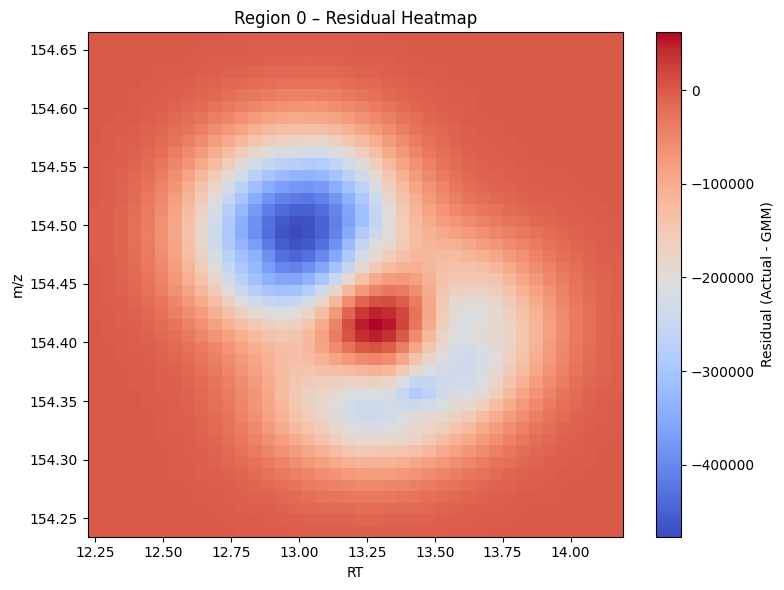

In [101]:
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

def plot_residual_heatmap(grid, mz_axis, rt_axis, gmm, scaler, region_idx):
    # Create coordinate grid
    grid = np.array(grid, dtype=float)  # ← Add this line
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X_grid = np.column_stack([mz_coords.ravel(), rt_coords.ravel()])


    mz_range = mz_axis.max() - mz_axis.min()
    rt_range = rt_axis.max() - rt_axis.min()
    mz_boost = rt_range / mz_range 

    # Apply same anisotropy as used in model training (IMPORTANT!)
    X_grid_aniso = X_grid.copy()
    X_grid_aniso[:, 0] *= mz_boost
    X_grid_scaled = scaler.transform(X_grid_aniso)

    # Reconstruct intensity from GMM
    recon = np.zeros(X_grid_scaled.shape[0])
    for mean, cov, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        rv = multivariate_normal(mean=mean, cov=cov)
        recon += weight * rv.pdf(X_grid_scaled)

    recon_grid = recon.reshape(grid.shape)

    # Avoid division by zero
    if recon_grid.max() != 0:
        recon_grid *= grid.max() / recon_grid.max()
    else:
        print("Warning: Reconstructed grid is all zeros.")
        recon_grid[:] = 0  # Just to be explicit

    residual = grid - recon_grid

    # Plot
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    plt.imshow(residual, extent=extent, origin='lower', aspect='auto', cmap='coolwarm')
    plt.title(f"Region {region_idx} – Residual Heatmap")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Residual (Actual - GMM)')
    plt.tight_layout()
    plt.show()

plot_residual_heatmap(grid=grid, mz_axis=mz_axis, rt_axis=rt_axis, gmm=best_gmm, scaler=scaler, region_idx=i)



✅ Positive Residuals
The GMM underestimates the intensity.

There is more signal in the actual data than what the GMM captures.

Suggests the GMM might have missed part of a peak.

✅ Negative Residuals
The GMM overestimates the intensity.

GMM is "seeing" structure that isn't strongly present in the real data.

Suggests overfitting or poor peak alignment.

✅ Zero Residual
Perfect fit.

The GMM’s prediction matches the original intensity at that point.